# In the first code cell of the Python notebook, install the necessary Google Cloud dependencies using the following command:

In [1]:
!python3 -m pip install --upgrade --quiet google-genai


In [1]:
!gcloud storage cp gs://qwiklabs-gcp-00-5087bf456b63-bucket/empty-bowl-on-empty-table.png .
!gcloud storage cp gs://qwiklabs-gcp-00-5087bf456b63-bucket/image_editing_utils.py .
!gcloud storage cp gs://qwiklabs-gcp-00-5087bf456b63-bucket/place-setting-mask.png .

Copying gs://qwiklabs-gcp-00-5087bf456b63-bucket/empty-bowl-on-empty-table.png to file://./empty-bowl-on-empty-table.png
  Completed files 1/1 | 1.4MiB/1.4MiB                                          

Average throughput: 129.1MiB/s
Copying gs://qwiklabs-gcp-00-5087bf456b63-bucket/image_editing_utils.py to file://./image_editing_utils.py
  Completed files 1/1 | 5.0kiB/5.0kiB                                          
Copying gs://qwiklabs-gcp-00-5087bf456b63-bucket/place-setting-mask.png to file://./place-setting-mask.png
  Completed files 1/1 | 4.5kiB/4.5kiB                                          


# Import the required libraries

In [2]:
from google import genai
from google.genai.types import (
    Image,
    EditImageConfig,
    RawReferenceImage,
    MaskReferenceImage,
    MaskReferenceConfig,
)

import image_editing_utils

# Initialize the Google Gen AI SDK with your project and location and define a bucket to be used.

In [3]:
PROJECT_ID = "qwiklabs-gcp-00-5087bf456b63"
LOCATION = "us-central1"
gcs_bucket = "qwiklabs-gcp-00-5087bf456b63-bucket"

client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION
)

Display the image of your product, a specific ceramic bowl. Throughout this lab, you will edit and enhance the surroundings of this bowl, but you will not allow it to be replaced with a generic different bowl

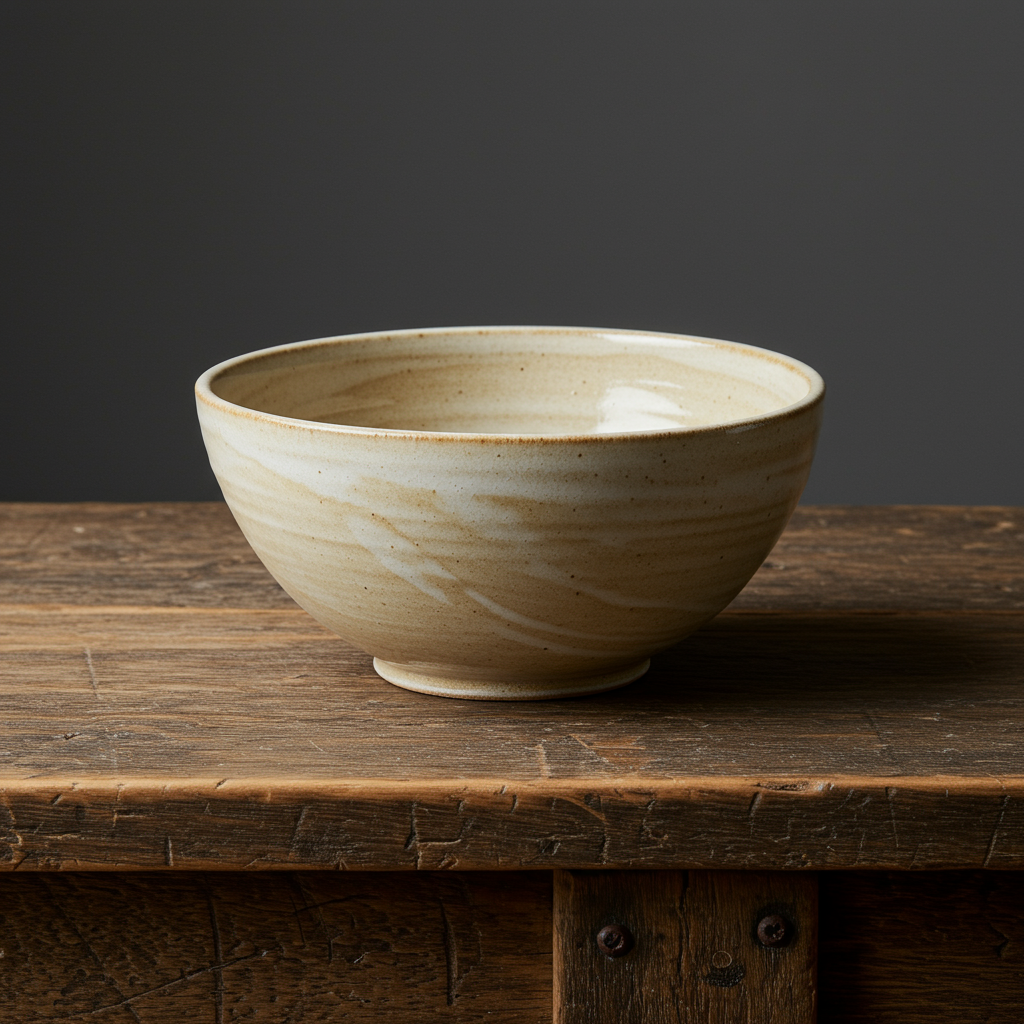

In [4]:
original_image = Image.from_file(
    location="empty-bowl-on-empty-table.png",
    mime_type="image/png"
)
original_image.show()

Run the following code to save your original_image locally and upload it to Cloud Storage:

In [5]:
dest_filename = "empty-bowl-on-empty-table-copy.png"
original_image.save(dest_filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, dest_filename, dest_filename)

File empty-bowl-on-empty-table-copy.png uploaded to empty-bowl-on-empty-table-copy.png.


# Task 2. Use outpainting to expand your product image's aspect ratio

The original image provided by the product photographer is framed tightly around the bowl. You will first expand the image to have more surrounding pixels to do further image editing.

In this lab, you will use the imagen-3.0-capability-001 image-editing version of Imagen to edit images. Store this model name with:

In [6]:
edit_model_name = "imagen-3.0-capability-001"

Use a helper function to make both:

a copy of the original image with blank space where you want to fill in
a mask that indicates with while pixels where the editing model should generate new image pixels

In [7]:
target_image_size = (1408, 768)

reframed_image, reframed_mask = image_editing_utils.pad_and_mask_image(
    original_image=original_image,
    target_size=target_image_size,
    vertical_offset_from_bottom=0.5,
    horizontal_offset_from_left=0.1,
)

# View the reframed image

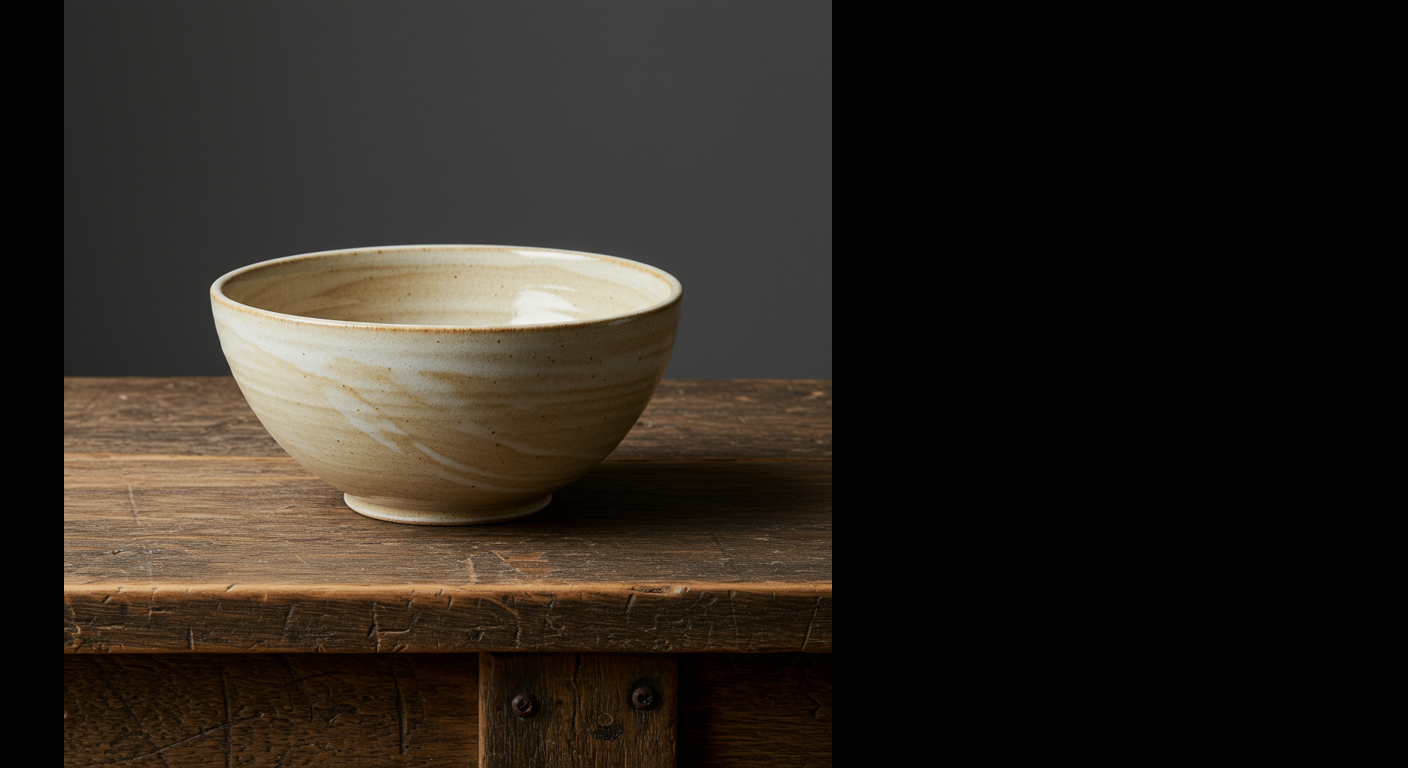

In [8]:
reframed_image.show()

# View the reframed mask 

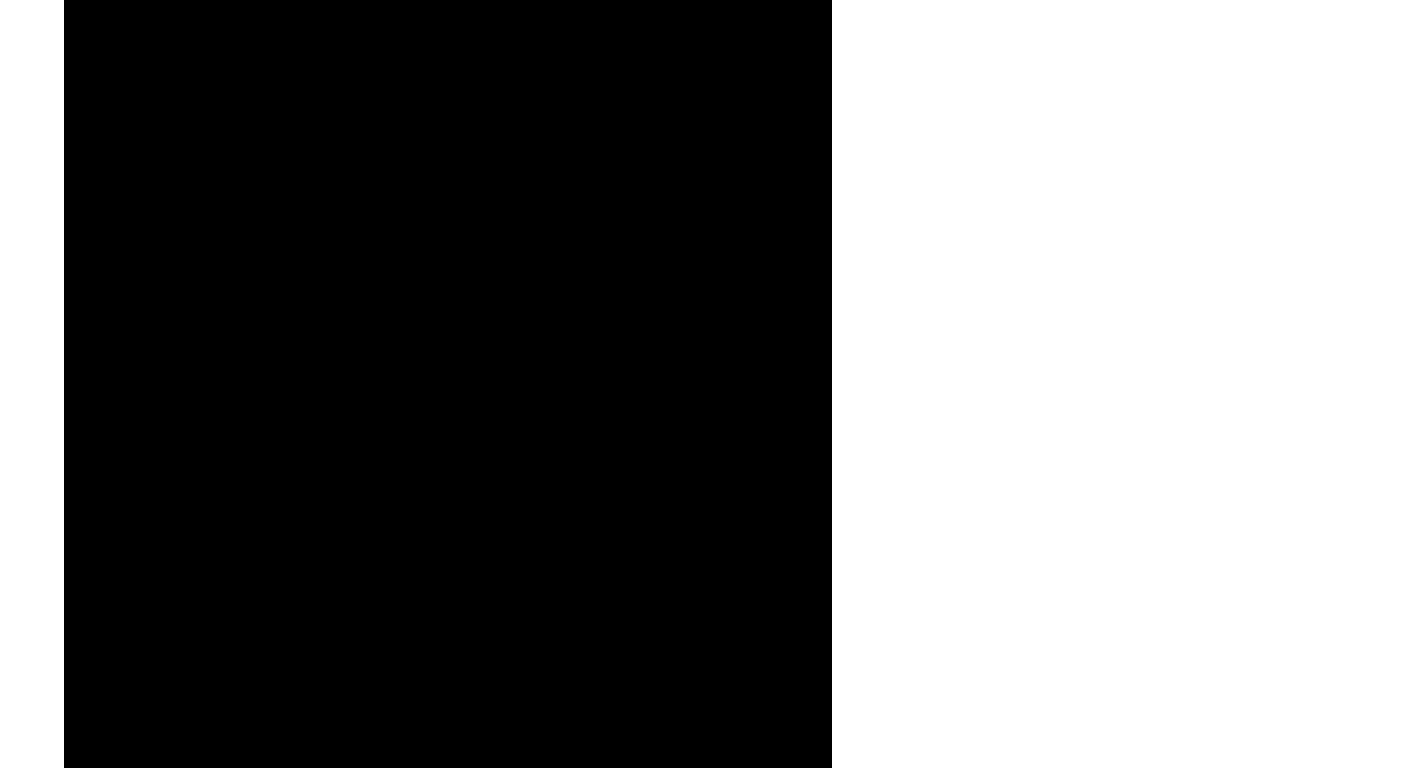

In [10]:
reframed_mask.show()

Prepare a RawReferenceImage referencing your reframed_image and a MaskReferenceImage referencing your reframed_mask and providing a MaskReferenceConfig that specifies that this is a user-provided mask:

In [14]:
raw_ref_image = RawReferenceImage(
    # Fill in the appropriate configuration
    reference_image=reframed_image,
    reference_id=0
)

mask_ref_image = MaskReferenceImage(
    reference_image=reframed_mask,
    reference_id=1,
    config=MaskReferenceConfig(
        mask_mode="MASK_MODE_USER_PROVIDED"
    ),
)

Replace #ENTER_THE_CORRECT_EDIT_MODE with the correct edit mode in the following cell and run it to expand the image to fill the empty pixels

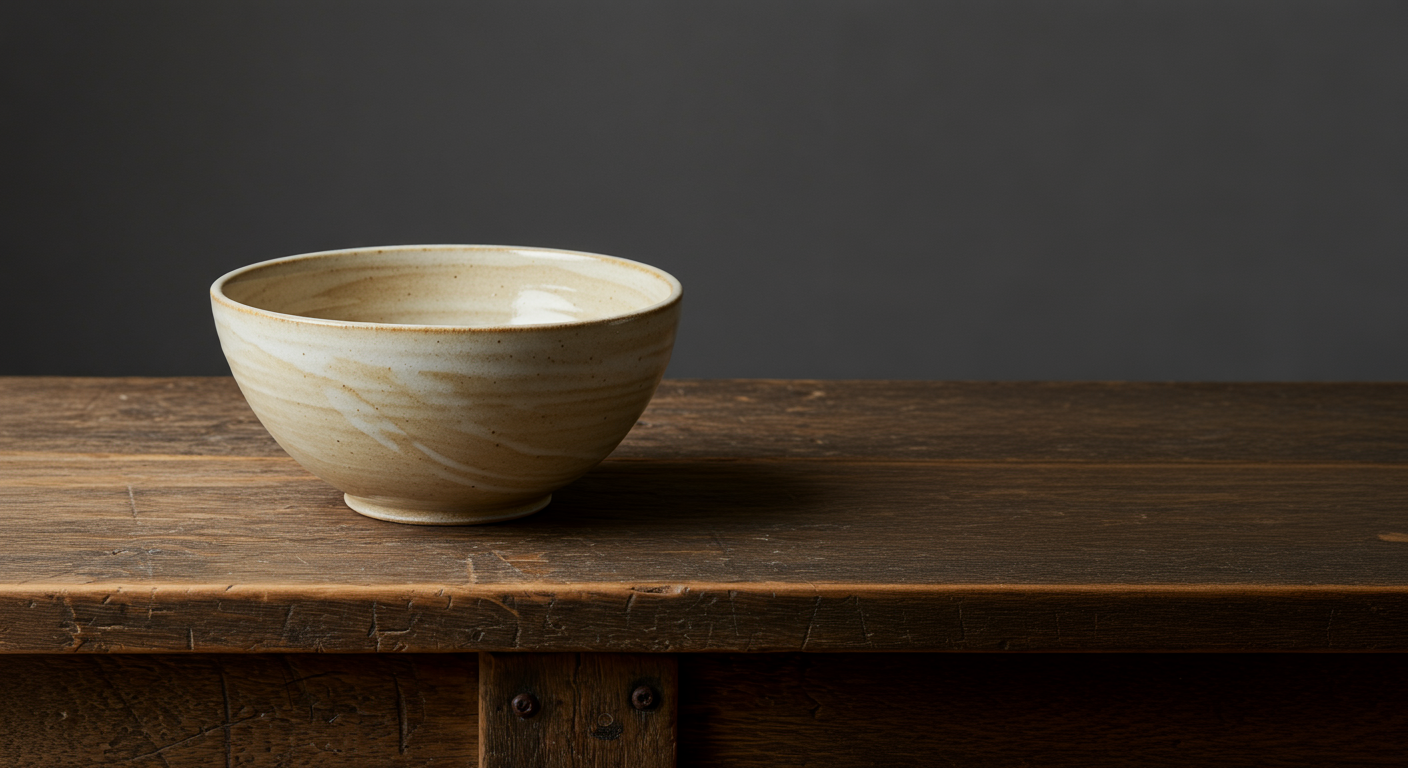

In [16]:
outpainted_image = client.models.edit_image(
    model=edit_model_name,
    prompt="",
    reference_images=[raw_ref_image, mask_ref_image],
    config=EditImageConfig(
        edit_mode= "EDIT_MODE_OUTPAINT" ,
        number_of_images=1,
        base_steps=35,
        safety_filter_level="BLOCK_ONLY_HIGH",
    ),
)

outpainted_image.generated_images[0].image.show()

Run the following code to save your outpainted_image locally and upload it to Cloud Storage:

In [17]:
filename = "empty-bowl-on-long-table.png"

outpainted_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

File empty-bowl-on-long-table.png uploaded to empty-bowl-on-long-table.png.


# Task 3. Use mask-free editing to make changes to overlapping objects

Your marketing team asks if you can put some grapes in the bowl. Because these items will overlap with the bowl itself, you don't want to mask anything about, but rather edit the image generally.

To make further edits on the image, reference the appropriate attribute of your outpainted_image to create a new RawReferenceImage.

In [ ]:
raw_ref_image = RawReferenceImage(
    reference_image= # Reference your outpainted image here,
    reference_id=0
)